# 1.Introduction/Business Problem

The city of Paris attracts more than 10 millions tourists per year. It is well known for for its museums, architecture, shopping and gastronomy. As a conseuqence, 
 the city have seen its averge house price grow by 9,1% en 2018 with an average property price around 
625 000 USD. Still, the demand is still greater than the supply and is driven by foreign investors traditionnaly from US and UK wealthy individual, and recently from
chinese and indians who are trusting the most pleasant areas of Paris, mainly the 6th, 7th and 8th arrondissement.

Also, as there is a shortage of disposable land to build, some neighborhood are experiencing positive mutations becoming trendy and very sought after. the best example, 
is the 3rd arrondissement better known as "le Marais" which was litterally in ruins and with a high crime rate in the late 80's, though becoming on of the most expensive area in Paris as of today.

In this context and as an investor in real estate (individual or corporation), it is important to comprehend what are the caracteristics that drive the price and attractivity of a particular area. 
Moreover, based on those findings, is it possible to determine which arrondissement could be the new "Marais" in the near futur. This analysis could
also be used by any investor trying to set up a business (restaurants, shops...) in a dynamic area.

# Data and methodology

Before using foursquare to obtain venues for each arrondissement (equivalent to neighberhood), I collected from different sources (Atelier parisien de l'urbanisme (APUR), Institut national de la statistique et des etudes économiques (INSEE), data.gouv.fr, chambre des notaires de Paris) variables which could represent the attractivity of an arrondissement. Starting from the available economic and social indicators for each arrondissement, I have choosen the following variables to discriminate between the 20 arrondissement of Paris :

A)Surface in sq/meters                                         
B)Number of hotels                                              
C)Number of rooms                                                   
D)Number of 1 star hotel                                                
E)Number of 2 star hotel                                                    
F)Number of 3 star hotel                                                 
G)Number of 4 star hotel                                                   
H)Number of 5 star hotel                                                
I)Median revenu per household                                             
J)Poverty rate                                                        
K)Average price per metre/sq                                                
L)Evolution of housing price (compound annual growth over 5 years)                                   
M)Median household revenue                                                   
N)Official coordinates of the arrondissement                                    



(NB: for viewing the map please open the following link  https://gist.github.com/dumpill/71ab25ffdf5269c4c7de82aedcfadfc1 on
https://nbviewer.jupyter.org)


The dimension of the dataframe is then 20x14 and looks like the following:

In [2]:
! pip install xlrd
! pip install geopy
! pip install folium
!conda install -c conda-forge folium=0.5.0 --yes
import folium
import pandas as pd
import numpy as np
import requests
import json
from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim
from IPython.display import Image 
from IPython.core.display import HTML 
import matplotlib.cm as cm
import matplotlib.colors as colors
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

     |████████████████████████████████| 92kB 14.1MB/s eta 0:00:01
Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    altair-4.0.0               |             py_0         606 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ------------------------------------------------------------
                                   

# Loading the database of the neighberhoods and their economical and social data

In [3]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_c3fd35aaff854e2cb20b40298907dad3 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='_lyasd6xyGs-d5kIScO3Zk57SEK4k-cN9HD5aF6C-oE_',
    ibm_auth_endpoint="https://iam.eu-gb.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_c3fd35aaff854e2cb20b40298907dad3.get_object(Bucket='donne-donotdelete-pr-tclcgydqyom5zt',Key='Cap.xlsx')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_0 = pd.read_excel(body)
df_data_0.head()
arrond=df_data_0.head()


Visualization of the 2O arrondissement (neighberhood) of Paris on a map

In [4]:
address = 'Paris'
geolocator = Nominatim(user_agent="par_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
centre = [latitude, longitude]
print('The geograpical coordinate of Paris are {}, {}.'.format(latitude, longitude))
Paris = folium.Map(location= centre, zoom_start = 13)
for lat, lng, label in zip(arrond.Lat, arrond.Lon, arrond.Arrond):
    folium.CircleMarker(
        [lat, lng],
        radius=5, # define how big you want the circle markers to be
        color='yellow',
        fill=True,
        popup=label,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(Paris)
Paris  

The geograpical coordinate of Paris are 48.8566101, 2.3514992.


# Getting venues for each arrondissement

The next step was to add the 50 venues begininng from the center of an arrondissement. There was one adjustement to make relative to the 12th arrondissement (Reuilly), because as you can see below, half of the arrondissement is constituted by the "forest of Vincennes". Thus I moved the center of the 12th arrondissement and subtract the surface of "forest of Vincennes".

In [5]:
location12= [48.834974, 2.421325]
arrondissement12 = folium.Map(location=location12, zoom_start = 14)
arrondissement12

The next step is using foursquare for each arrondissement (2O calls) to get the venues. Below is an example of venues call for the 1st arrondissement.

In [6]:
####example call venues for the 1st arrondissement
CLIENT_ID = 'JYHRIL2ETQWSDJP4LE05F1AV1TEH4LFHRPAKY1UA5UFH5MD5' # your Foursquare ID
CLIENT_SECRET = 'FHCXEBEBIEO1G4NMNKFMKK1CHUW3UL4WKYNHQ3BSAKDQN35F' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
latitude1 = 48.8625627
longitude1 = 2.336443362
print(latitude1, longitude1)
LIMIT=50
radius = 500
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude1, longitude1, VERSION, radius, LIMIT)
results1 = requests.get(url).json()
results1 = requests.get(url).json()
'There are {} venues around 1er arrond.'.format(len(results1['response']['groups'][0]['items']))
items1 = results1['response']['groups'][0]['items']
items1[0]
dataframe1 = json_normalize(items1) # flatten JSON
filtered_columns1 = ['venue.name', 'venue.categories'] + [col for col in dataframe1.columns if col.startswith('venue.location.')] + ['venue.id']
dataframe_filtered1 = dataframe1.loc[:, filtered_columns1]
dataframe_filtered1['venue.categories'] = dataframe_filtered1.apply(get_category_type, axis=1)
dataframe_filtered1.columns = [col.split('.')[-1] for col in dataframe_filtered1.columns]
dataframe_filtered1.head()

Your credentails:
CLIENT_ID: JYHRIL2ETQWSDJP4LE05F1AV1TEH4LFHRPAKY1UA5UFH5MD5
CLIENT_SECRET:FHCXEBEBIEO1G4NMNKFMKK1CHUW3UL4WKYNHQ3BSAKDQN35F
48.8625627 2.336443362


,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
0,Musée du Louvre,Art Museum,Rue de Rivoli,FR,Paris,France,Place du Carrousel,190,"[Rue de Rivoli (Place du Carrousel), 75001 Par...","[{'label': 'display', 'lat': 48.86084691113991...",48.860847,2.336440,Le Louvre,75001,Île-de-France,4adcda10f964a520af3521e3
1,Palais Royal,Historic Site,Place du Palais Royal,FR,Paris,France,NaN,90,"[Place du Palais Royal, 75001 Paris, France]","[{'label': 'display', 'lat': 48.86323576771446...",48.863236,2.337127,NaN,75001,Île-de-France,4adcda09f964a520ed3321e3
2,Comédie-Française,Theater,1 place Colette,FR,Paris,France,NaN,59,"[1 place Colette, 75001 Paris, France]","[{'label': 'display', 'lat': 48.86308790118613...",48.863088,2.336612,Palais-Royal,75001,Île-de-France,4b48b4b0f964a5207c5326e3
3,Cour Napoléon,Plaza,Place du Carrousel,FR,Paris,France,NaN,183,"[Place du Carrousel, 75001 Paris, France]","[{'label': 'display', 'lat': 48.86117159622847...",48.861172,2.335088,NaN,75001,Île-de-France,5072efe7e4b0c34b5146e7fd
4,Place du Palais Royal,Plaza,Place du Palais Royal,FR,Paris,France,NaN,18,"[Place du Palais Royal, 75001 Paris, France]","[{'label': 'display', 'lat': 48.86252338167934...",48.862523,2.336688,NaN,75001,Île-de-France,4b071505f964a520dcf622e3


As Paris is very dense, thus having numerous types of venues, I kept the 5 most appearing categories adding them to the intitial database (economic and social indicators of each arrondissement) which is below. We have 20 obervations and 19 variables, we will probably have to reduce the dimension before applying the segmentation.

# Importing the data with all the indicators: economic, scial and venues

In [7]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_c3fd35aaff854e2cb20b40298907dad3 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='P-aAgkXbHp-Vl64Fanr2mQMiuZBwWupaK6oag19WbvI2',
    ibm_auth_endpoint="https://iam.eu-gb.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_c3fd35aaff854e2cb20b40298907dad3.get_object(Bucket='capstoneprojectfinal-donotdelete-pr-kjnd3gc1xrbdup',Key='Capstone_data.xlsx')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_0 = pd.read_excel(body)
df_data_0.head()
data=df_data_0
data

,Arrond,SURFACE,1st common venue,2nd common venue,3rd common venue,4rth common venue,5th common venue,Nb_rooms,Nb_hotels,1 star,2 stars,3 stars,4 stars,5 stars,Average_price_msq,growth 5 years,Pover_rate,Med_household_rev,Lat,Lon
0,Louvre,1.824613e+06,restaurant,cafe,hotel,plaza,historic site,3841,66,0,6,21,25,14,12840,0.277,11,31842.555556,48.862563,2.336443
1,Bourse,9.911537e+05,restaurant,bar,hotel,bakery,cafe,1703,38,1,3,17,16,1,11250,0.224,15,30024.500000,48.868279,2.342803
2,Temple,1.170883e+06,restaurant,bar,cafe,clothing store,boutique,801,22,0,3,10,8,1,12260,0.245,13,30988.000000,48.862872,2.360001
3,Hotel de ville,1.600586e+06,restaurant,bar,ice cream shop,hotel,art venue,817,30,1,4,18,6,1,12790,0.137,12,30514.666667,48.854341,2.357630
4,Pantheon,2.539375e+06,restaurant,bar,historic site,plaza,bakery,2637,70,1,14,35,20,0,12140,0.218,11,32950.000000,48.844443,2.350715
5,Luxembourg,2.153096e+06,restaurant,bakery,bar,hotel,art venue,3362,91,1,9,37,38,6,14180,0.201,9,38447.692308,48.849130,2.332898
6,Palais-bourbon,4.090057e+06,restaurant,hotel,historic site,plaza,art venue,1961,56,0,4,28,20,4,13230,0.196,8,41949.000000,48.856174,2.312188
7,Elysee,3.880036e+06,restaurant,hotel,bakery,art venue,spa,8121,131,1,6,37,56,31,11240,0.204,10,39774.000000,48.872721,2.312554
8,Opera,2.178303e+06,restaurant,hotel,bakery,bar,art venue,7751,161,2,21,88,43,7,10730,0.282,12,32771.000000,48.877164,2.337458
9,Enclos saint laurent,2.891739e+06,restaurant,cafe,bar,bakery,bookstore,4851,98,5,28,49,15,1,9730,0.319,18,25154.000000,48.876130,2.360728


Deleting the 1st common venue as it is common to all the arrondissement

In [22]:
x=data[['Arrond','1st common venue']]
x

,Arrond,1st common venue
0,Louvre,restaurant
1,Bourse,restaurant
2,Temple,restaurant
3,Hotel de ville,restaurant
4,Pantheon,restaurant
5,Luxembourg,restaurant
6,Palais-bourbon,restaurant
7,Elysee,restaurant
8,Opera,restaurant
9,Enclos saint laurent,restaurant


# Methodology

# I. Exploratory analysis

Now that we have our database, the first step is to start with an exploratory analysis trough descriptive statistics and data visualization.

In [12]:
data.columns.values
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)
data.columns.values

array(['Arrond', 'SURFACE', '1st common venue', '2nd common venue',
       '3rd common venue', '4rth common venue', '5th common venue',
       'Nb_rooms', 'Nb_hotels', '1 star', '2 stars', '3 stars', '4 stars',
       '5 stars', 'Average_price_msq', 'growth 5 years', 'Pover_rate',
       'Med_household_rev', 'Lat', 'Lon'], dtype=object)

First, let's try to reduce the dimension i.e resuming the information contained in our variable if they are not relevant or redundant. Clearly, the columns containing the coordinates will be removed because it doesn't provide any useful information nor have the power to differenciate between the arrondissement. same thing goes for the column "1st most common venue" as the venue "restaurant" is almost common to all the arrondissement. Moreover, the number rooms and the number of hotels are strongly positively correlated (=0,91) and represent the same information, we will keep the number of hotels as it is a better indicator of the accomodation capacity.

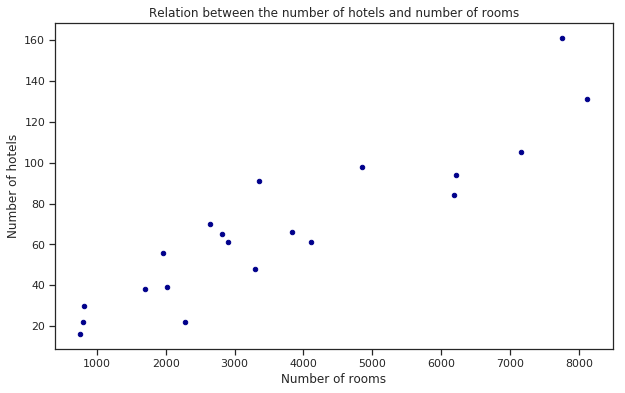

0.9120016821935968


In [24]:
data.plot(kind='scatter', x='Nb_rooms', y='Nb_hotels', figsize=(10, 6), color='darkblue')

plt.title('Relation between the number of hotels and number of rooms')
plt.xlabel('Number of rooms')
plt.ylabel('Number of hotels')
plt.show()
correlation=data['Nb_rooms'].corr(data['Nb_hotels'])
print (correlation)

Droping non relevant variable for the analysis.

In [22]:
data1=data.drop(['1st common venue', 'Nb_hotels','Lat','Lon'], axis=1)
data1.head()

,Arrond,SURFACE,2nd common venue,3rd common venue,4rth common venue,5th common venue,Nb_rooms,1 star,2 stars,3 stars,4 stars,5 stars,Average_price_msq,growth 5 years,Pover_rate,Med_household_rev
0,Louvre,1.824613e+06,cafe,hotel,plaza,historic site,3841,0,6,21,25,14,12840,0.277,11,31842.555556
1,Bourse,9.911537e+05,bar,hotel,bakery,cafe,1703,1,3,17,16,1,11250,0.224,15,30024.500000
2,Temple,1.170883e+06,bar,cafe,clothing store,boutique,801,0,3,10,8,1,12260,0.245,13,30988.000000
3,Hotel de ville,1.600586e+06,bar,ice cream shop,hotel,art venue,817,1,4,18,6,1,12790,0.137,12,30514.666667
4,Pantheon,2.539375e+06,bar,historic site,plaza,bakery,2637,1,14,35,20,0,12140,0.218,11,32950.000000


Now let's have a look at correlations among columns is by visualizing the correlation matrix as a heatmap.

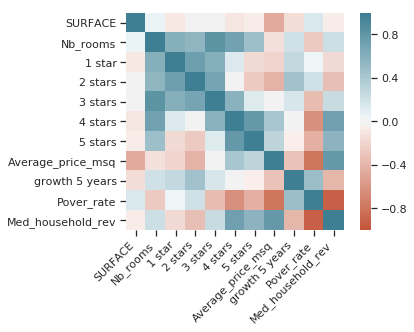

In [23]:
corr = data1.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

From the matrix correlation, we can see that there are significant positive correlation between the number of hotel stars and the number of rooms, between the median household revenue and the number of hotel stars/the average per square meter. There are also negative correlation between the poverty rate and the number of hotels stars/average price per square meter/Median householde revenue.

# Let's look at the variables scatterplots to have more insights

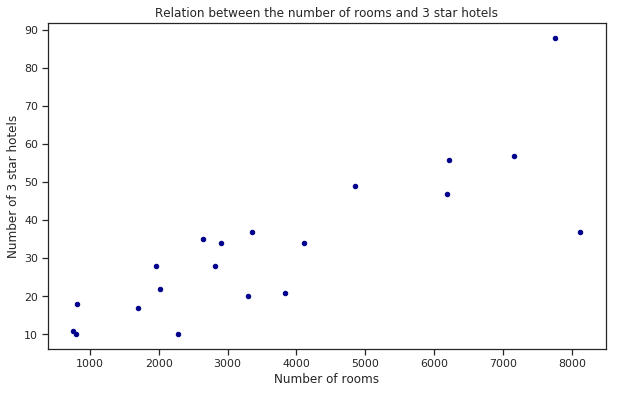

In [25]:
data.plot(kind='scatter', x='Nb_rooms', y='3 stars', figsize=(10, 6), color='darkblue')
plt.title('Relation between the number of rooms and 3 star hotels')
plt.xlabel('Number of rooms')
plt.ylabel('Number of 3 star hotels')
plt.show()

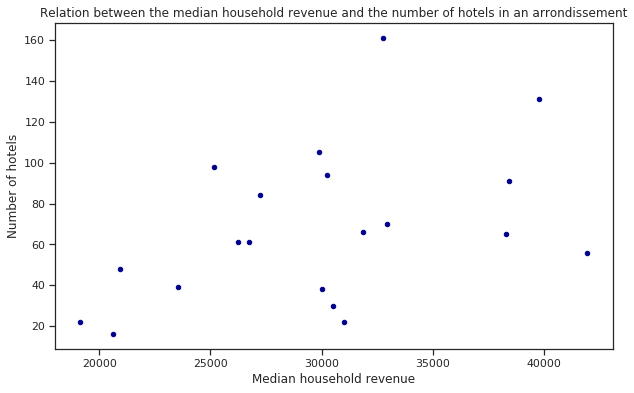

In [26]:
data.plot(kind='scatter', x='Med_household_rev', y='Nb_hotels', figsize=(10, 6), color='darkblue')
plt.title('Relation between the median household revenue and the number of hotels in an arrondissement')
plt.xlabel('Median household revenue')
plt.ylabel('Number of hotels')
plt.show()
#the number of hotels increase with the median household revenu, indicating that those arrondissement
#potentially more attractive in terms of purchasing power leading which probably increase the 
#number of venues

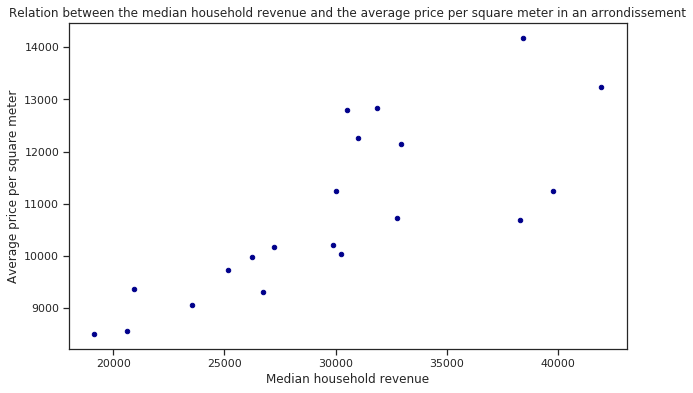

In [26]:
data.plot(kind='scatter', x='Med_household_rev', y='Average_price_msq', figsize=(10, 6), color='darkblue')
plt.title('Relation between the median household revenue and the average price per square meter in an arrondissement')
plt.xlabel('Median household revenue')
plt.ylabel('Average price per square meter')
plt.show()

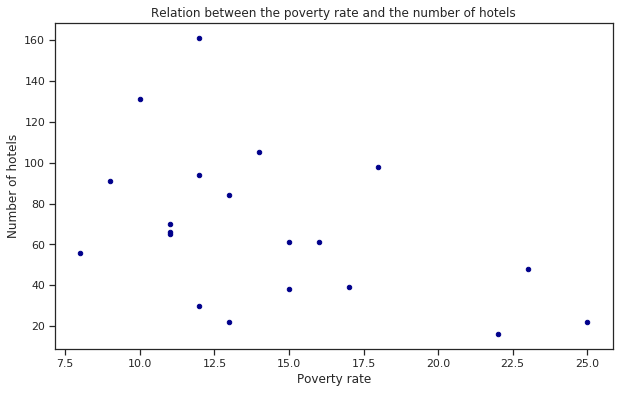

In [27]:
data.plot(kind='scatter', x='Pover_rate', y='Nb_hotels', figsize=(10, 6), color='darkblue')
plt.title('Relation between the poverty rate and the number of hotels')
plt.xlabel('Poverty rate')
plt.ylabel('Number of hotels')
plt.show()

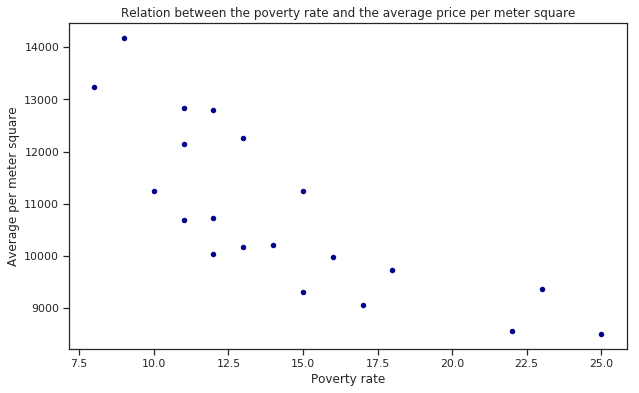

In [28]:
data.plot(kind='scatter', x='Pover_rate', y='Average_price_msq', figsize=(10, 6), color='darkblue')
plt.title('Relation between the poverty rate and the average price per meter square')
plt.xlabel('Poverty rate')
plt.ylabel('Average per meter square')
plt.show()

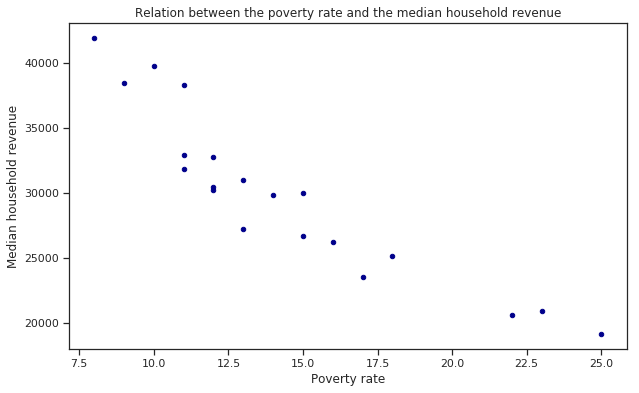

In [29]:
data.plot(kind='scatter', x='Pover_rate', y='Med_household_rev', figsize=(10, 6), color='darkblue')
plt.title('Relation between the poverty rate and the median household revenue')
plt.xlabel('Poverty rate')
plt.ylabel('Median household revenue')
plt.show()

In regards to the scatter plots above, we can draw some preliminary and pretty obvious conclusions for a hypothetical investor (hotel, real estate, or whealthy individual) based on the exploratory analysis:

1. the higher the median household income in an arrondissement the higher the number of hotels and the price per meter square.
2. The lower the poverty rate the higher the higher the attractivity of the arrondissement (higher household income, more hotels, higher price per meter square)
3. The type of hotels that have the greater capcity of accomodation (number of rooms) are the 3 and 4 stars.

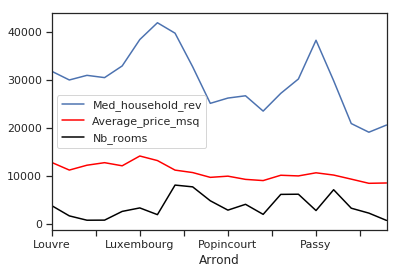

In [27]:
ax = plt.gca()

data.plot(kind='line',x='Arrond',y='Med_household_rev',ax=ax)
data.plot(kind='line',x='Arrond',y='Average_price_msq', color='red', ax=ax)
data.plot(kind='line',x='Arrond',y='Nb_rooms', color='black', ax=ax)
plt.show()

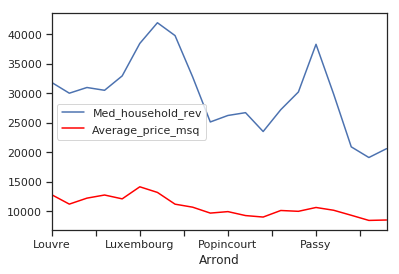

In [28]:
ax = plt.gca()

data.plot(kind='line',x='Arrond',y='Med_household_rev',ax=ax)
data.plot(kind='line',x='Arrond',y='Average_price_msq', color='red', ax=ax)

plt.show()

Venues don't have any effect on indicator the neighberhoods, see below example of the distribution of type of venue and the average price per square meter 

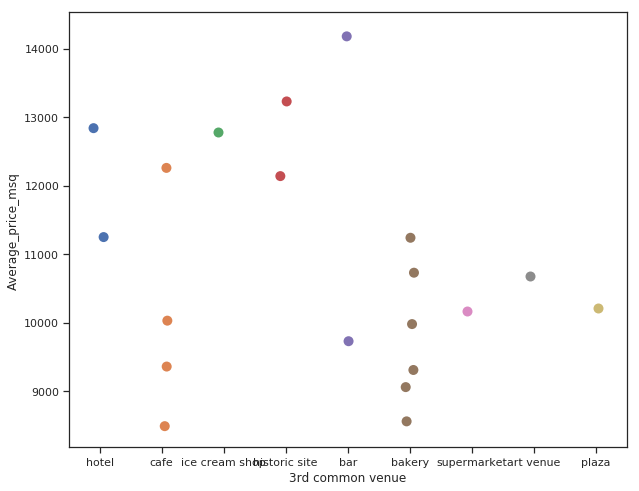

In [46]:
sns.stripplot(x="3rd common venue", y="Average_price_msq",size=10, data=data)
plt.rcParams['figure.figsize'] = (8, 10)

# II segmentation and clustering

In [13]:
#tranforming the categorical variable into dummies before using k-means
dataseg = pd.concat([data,pd.get_dummies(data['2nd common venue'])], axis=1)
datas=dataseg.drop(['Arrond','1st common venue','2nd common venue', '3rd common venue'
                    ,'4rth common venue','5th common venue','Lat',
                    'Lon', 'Nb_hotels', 'SURFACE', 'growth 5 years'], axis=1)
datas

,Nb_rooms,1 star,2 stars,3 stars,4 stars,5 stars,Average_price_msq,Pover_rate,Med_household_rev,bakery,bar,cafe,hotel,juice bar,plaza
0,3841,0,6,21,25,14,12840,11,31842.555556,0,0,1,0,0,0
1,1703,1,3,17,16,1,11250,15,30024.500000,0,1,0,0,0,0
2,801,0,3,10,8,1,12260,13,30988.000000,0,1,0,0,0,0
3,817,1,4,18,6,1,12790,12,30514.666667,0,1,0,0,0,0
4,2637,1,14,35,20,0,12140,11,32950.000000,0,1,0,0,0,0
5,3362,1,9,37,38,6,14180,9,38447.692308,1,0,0,0,0,0
6,1961,0,4,28,20,4,13230,8,41949.000000,0,0,0,1,0,0
7,8121,1,6,37,56,31,11240,10,39774.000000,0,0,0,1,0,0
8,7751,2,21,88,43,7,10730,12,32771.000000,0,0,0,1,0,0
9,4851,5,28,49,15,1,9730,18,25154.000000,0,0,1,0,0,0


In [17]:
from sklearn.cluster import KMeans
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(datas)
    distortions.append(kmeanModel.inertia_)

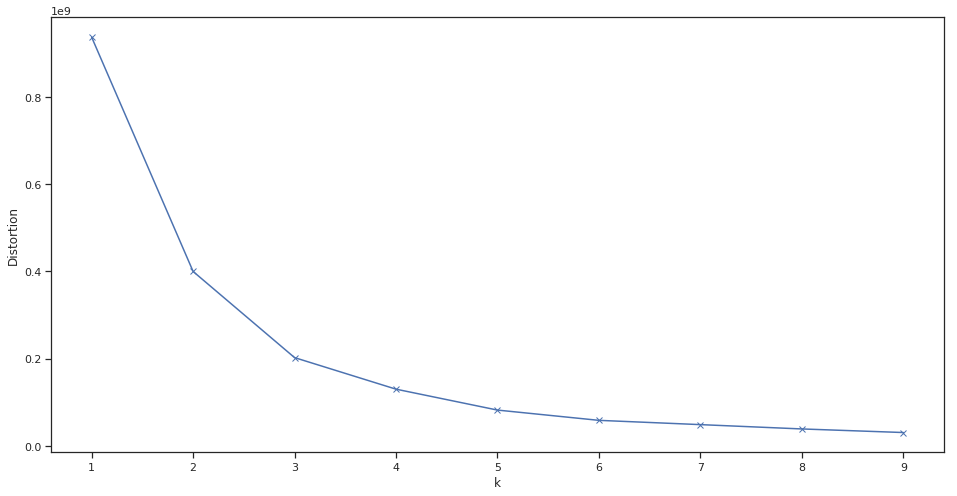

In [15]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')

plt.show()

In [22]:
#K means with k=3
kclusters = 3
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(datas)
kmeans.labels_[0:20]

array([2, 2, 2, 2, 2, 1, 1, 1, 2, 0, 0, 0, 0, 0, 2, 1, 2, 0, 0, 0],
      dtype=int32)

In [23]:
data.insert(0, 'cluster_k=3', kmeans.labels_)

In [24]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

In [25]:
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(data['Lat'], data['Lon'], data['Arrond'], data['cluster_k=3']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [51]:
data.loc[data['cluster_k=3'] == 0, data.columns[[1] + list(range(4, data.shape[1]))]]


,Arrond,2nd common venue,3rd common venue,4rth common venue,5th common venue,Nb_rooms,Nb_hotels,1 star,2 stars,3 stars,4 stars,5 stars,Average_price_msq,growth 5 years,Pover_rate,Med_household_rev,Lat,Lon
9,Enclos saint laurent,cafe,bar,bakery,bookstore,4851,98,5,28,49,15,1,9730,0.319,18,25154.000000,48.876130,2.360728
10,Popincourt,bar,bakery,cafe,art venue,2901,61,1,17,34,8,1,9980,0.261,16,26253.000000,48.859059,2.380058
11,Reuilly,hotel,bakery,supermarket,bar,4113,61,1,16,34,10,0,9310,0.201,15,26729.000000,48.834974,2.421325
12,Gobelins,juice bar,bakery,park,cosmetics shop,2020,39,0,10,22,7,0,9060,0.172,17,23538.181818,48.828388,2.362272
13,Observatoire,bakery,supermarket,cafe,plaza,6182,84,5,18,47,14,0,10170,0.196,13,27233.000000,48.829245,2.326542
17,Butte montmartre,bar,cafe,hotel,theater,3303,48,2,14,20,12,0,9360,0.313,23,20942.000000,48.892569,2.348161
18,Buttes chaumont,bar,cafe,supermarket,hotel,2279,22,0,10,10,2,0,8490,0.266,25,19136.956522,48.887076,2.384821
19,Ménilmontant,bar,bakery,plaza,park,758,16,0,5,11,0,0,8560,0.245,22,20632.000000,48.863461,2.401188


In [52]:
data.loc[data['cluster_k=3'] == 1, data.columns[[1] + list(range(4, data.shape[1]))]]

,Arrond,2nd common venue,3rd common venue,4rth common venue,5th common venue,Nb_rooms,Nb_hotels,1 star,2 stars,3 stars,4 stars,5 stars,Average_price_msq,growth 5 years,Pover_rate,Med_household_rev,Lat,Lon
5,Luxembourg,bakery,bar,hotel,art venue,3362,91,1,9,37,38,6,14180,0.201,9,38447.692308,48.849130,2.332898
6,Palais-bourbon,hotel,historic site,plaza,art venue,1961,56,0,4,28,20,4,13230,0.196,8,41949.000000,48.856174,2.312188
7,Elysee,hotel,bakery,art venue,spa,8121,131,1,6,37,56,31,11240,0.204,10,39774.000000,48.872721,2.312554
15,Passy,plaza,art venue,pool,restaurant,2816,65,0,4,28,25,8,10680,0.204,11,38299.000000,48.860392,2.261971


In [53]:
data.loc[data['cluster_k=3'] == 2, data.columns[[1] + list(range(4, data.shape[1]))]]

,Arrond,2nd common venue,3rd common venue,4rth common venue,5th common venue,Nb_rooms,Nb_hotels,1 star,2 stars,3 stars,4 stars,5 stars,Average_price_msq,growth 5 years,Pover_rate,Med_household_rev,Lat,Lon
0,Louvre,cafe,hotel,plaza,historic site,3841,66,0,6,21,25,14,12840,0.277,11,31842.555556,48.862563,2.336443
1,Bourse,bar,hotel,bakery,cafe,1703,38,1,3,17,16,1,11250,0.224,15,30024.500000,48.868279,2.342803
2,Temple,bar,cafe,clothing store,boutique,801,22,0,3,10,8,1,12260,0.245,13,30988.000000,48.862872,2.360001
3,Hotel de ville,bar,ice cream shop,hotel,art venue,817,30,1,4,18,6,1,12790,0.137,12,30514.666667,48.854341,2.357630
4,Pantheon,bar,historic site,plaza,bakery,2637,70,1,14,35,20,0,12140,0.218,11,32950.000000,48.844443,2.350715
8,Opera,hotel,bakery,bar,art venue,7751,161,2,21,88,43,7,10730,0.282,12,32771.000000,48.877164,2.337458
14,Vaugirard,hotel,cafe,bakery,art venue,6218,94,2,17,56,19,0,10030,0.199,12,30227.333333,48.840085,2.292826
16,Batignolles monceau,hotel,plaza,bakery,art venue,7153,105,4,13,57,29,2,10210,0.255,14,29872.000000,48.887327,2.306777


In [56]:
datanalyse=data.drop(['Arrond','1st common venue','2nd common venue', '3rd common venue'
                    ,'4rth common venue','5th common venue','Lat',
                    'Lon', 'SURFACE', 'Nb_hotels'], axis=1)
datanalyse.groupby('cluster_k=3').mean()

,Nb_rooms,1 star,2 stars,3 stars,4 stars,5 stars,Average_price_msq,growth 5 years,Pover_rate,Med_household_rev
cluster_k=3,,,,,,,,,,
0,3300.875,1.750,14.750,28.375,8.50,0.25,9332.50,0.246625,18.625,23702.267292
1,4065.000,0.500,5.750,32.500,34.75,12.25,12332.50,0.201250,9.500,39617.423077
2,3865.125,1.375,10.125,37.750,20.75,3.25,11531.25,0.229625,12.500,31148.756944
